In [7]:
# Disable all warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os

if not os.path.exists('../../data/replogle22/replogle22_processed.h5ad'):
    os.system('aws s3 cp s3://shift-personal-dev/henry/icml_data/replogle22/replogle22_processed.h5ad ../../data/replogle22/replogle22_processed.h5ad')

if not os.path.exists('../../data/replogle22/replogle22_names_df_vsrest.pkl'):
    os.system('aws s3 cp s3://shift-personal-dev/henry/icml_data/replogle22/replogle22_names_df_vsrest.pkl ../../data/replogle22/replogle22_names_df_vsrest.pkl')

if not os.path.exists('../../data/replogle22/replogle22_scores_df_vsrest.pkl'):
    os.system('aws s3 cp s3://shift-personal-dev/henry/icml_data/replogle22/replogle22_scores_df_vsrest.pkl ../../data/replogle22/replogle22_scores_df_vsrest.pkl')

In [10]:
import numpy as np
import pandas as pd

# Read the numpy files
try:
    names_df_vsrest = np.load('../../data/replogle22/replogle22_names_df_vsrest.pkl', allow_pickle=True)
    print("Successfully loaded names_df_vsrest")
except Exception as e:
    print(f"Error loading names_df_vsrest: {e}")

try:
    scores_df_vsrest = np.load('../../data/replogle22/replogle22_scores_df_vsrest.pkl', allow_pickle=True)
    print("Successfully loaded scores_df_vsrest")
except Exception as e:
    print(f"Error loading scores_df_vsrest: {e}")


Successfully loaded names_df_vsrest
Successfully loaded scores_df_vsrest


In [11]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from scipy.stats import ranksums # Added ranksums
import scienceplots

import sys
sys.path.append(os.path.dirname(os.getcwd())) # For finding the 'analyses' package
from common import *


DATASET_NAME = 'replogle22'

# Initialize analysis using the common function
(
    adata,
    pert_means, # This is the dictionary from get_pert_means(adata) 
    total_mean_original,
    ctrl_mean_original,
    DATASET_NAME,
    DATASET_CELL_COUNTS,
    DATASET_PERTS_TO_SWEEP,
    dataset_specific_subdir, # e.g. "norman19" or "replogle22"
    DATA_CACHE_DIR, # Base cache dir, e.g., "../../../data/"
    original_np_random_state,
    ANALYSIS_DIR,
    pert_normalized_abs_scores_vsrest,
    pert_counts,
    scores_df_vsrest,
    names_df_vsrest,
) = initialize_analysis(DATASET_NAME, 'modeling_with_gears')

loss_weights_dict = {}
for key in pert_normalized_abs_scores_vsrest.keys():
    loss_weights_dict[key+'+ctrl'] = 100*pert_normalized_abs_scores_vsrest.get(key).values

Calculating WMSE Weights: 100%|██████████| 1335/1335 [00:01<00:00, 887.01it/s]


In [24]:
# Import required libraries
from gears import PertData
from gears_icml import GEARS
import pickle

# Check if all prediction files exist
prediction_files = [
    '../../data/gears_predictions_mse_unweighted.pkl',
    '../../data/gears_predictions_mse_weighted.pkl',
    '../../data/gears_predictions_default_loss_unweighted.pkl',
    '../../data/gears_predictions_default_loss_weighted.pkl'
]

if all(os.path.exists(f) for f in prediction_files):
    print("All prediction files exist. Loading predictions...")
    gears_predictions = {}
    for loss in ['mse', 'default_loss']:
        for weight in ['unweighted', 'weighted']:
            with open(f'../../data/gears_predictions_{loss}_{weight}.pkl', 'rb') as f:
                gears_predictions[f'{loss}_{weight}'] = pickle.load(f)
else:
    # ===================GEARS DATA PREPARATION ===================
    print("Starting GEARS data preparation...")

    gears_predictions = {}

    # Create a copy of the original data and subsample cells
    print("Creating data copy...")
    adata_gears = adata.copy()
    np.random.seed(42)  # Set random seed for reproducibility

    # Process condition labels
    print("Processing condition labels...")
    adata_gears.obs['condition'] = adata_gears.obs['condition'].astype(str) + '+ctrl'
    adata_gears.obs['condition'] = adata_gears.obs['condition'].str.replace('control+ctrl', 'ctrl')

    # Get unique perturbations
    print("Getting unique perturbations...")
    all_perturbations = adata_gears.obs['condition'].unique()
    all_perturbations = all_perturbations[all_perturbations != 'ctrl']
    print(f"Found {len(all_perturbations)} unique perturbations")

    # Split perturbations into first and second half
    print("Splitting perturbations into halves...")
    first_half_perturbations = all_perturbations[:len(all_perturbations)//2]
    second_half_perturbations = all_perturbations[len(all_perturbations)//2:]
    print(f"First half: {len(first_half_perturbations)} perturbations")
    print(f"Second half: {len(second_half_perturbations)} perturbations")

    # Process first half splits
    print("\nProcessing first half splits...")
    first_half_train_val = first_half_perturbations
    np.random.shuffle(first_half_train_val)
    split_idx = int(len(first_half_train_val) * 0.9) # 90% train, 10% val
    first_half_train = first_half_train_val[:split_idx]
    first_half_val = first_half_train_val[split_idx:]

    first_half_split_dict = {
        'train': first_half_train,
        'val': first_half_val,
        'test': first_half_perturbations  # All first half perturbations as test
    }
    print(f"First half splits - Train: {len(first_half_train)}, Val: {len(first_half_val)}")

    # Process second half splits
    print("\nProcessing second half splits...")
    second_half_train_val = second_half_perturbations
    np.random.shuffle(second_half_train_val) 
    split_idx = int(len(second_half_train_val) * 0.9)  # 90% train, 10% val
    second_half_train = second_half_train_val[:split_idx]
    second_half_val = second_half_train_val[split_idx:]

    second_half_split_dict = {
        'train': second_half_train,
        'val': second_half_val,
        'test': second_half_perturbations  # All second half perturbations as test
    }
    print(f"Second half splits - Train: {len(second_half_train)}, Val: {len(second_half_val)}")

    # Prepare data for GEARS
    print("\nPreparing data for GEARS...")
    # Add control to perturbation lists
    first_half_perturbations = np.concatenate([['ctrl'], first_half_perturbations])
    second_half_perturbations = np.concatenate([['ctrl'], second_half_perturbations])

    # Create subsetted datasets
    print("Creating subsetted datasets...")
    adata_first_half_gears = adata_gears[adata_gears.obs['condition'].isin(first_half_perturbations)].copy()
    adata_second_half_gears = adata_gears[adata_gears.obs['condition'].isin(second_half_perturbations)].copy()
    print(f"First half dataset size: {adata_first_half_gears.n_obs} cells")
    print(f"Second half dataset size: {adata_second_half_gears.n_obs} cells")

    # Process first half data
    print("\nProcessing first half data with GEARS...")
    pert_data_first_half = PertData('../../data')
    if not os.path.exists('../../data/replogle22_gears_first_half_gears'):
        pert_data_first_half.new_data_process(dataset_name='replogle22_gears_first_half_gears', adata=adata_first_half_gears)
    pert_data_first_half.load(data_path='../../data/replogle22_gears_first_half_gears')
    # Filter out genes not in gene2go from each split
    for split in ['train', 'val', 'test']:
        original_count = len(first_half_split_dict[split])
        first_half_split_dict[split] = [gene for gene in first_half_split_dict[split] 
                                    if gene.replace('+ctrl', '') in pert_data_first_half.gene2go.keys()]
        filtered_count = len(first_half_split_dict[split])
        print(f"{split} split: {filtered_count}/{original_count} genes kept ({original_count - filtered_count} removed)")
    with open('../../data/replogle22_gears_first_half_split_dict.pkl', 'wb') as f:
        pickle.dump(first_half_split_dict, f)
    pert_data_first_half.prepare_split(split='custom', seed=42, split_dict_path='../../data/replogle22_gears_first_half_split_dict.pkl')
    print("First half data processing complete")

    # Process second half data
    print("\nProcessing second half data with GEARS...")
    pert_data_second_half = PertData('../../data')
    if not os.path.exists('../../data/replogle22_gears_second_half_gears'):
        pert_data_second_half.new_data_process(dataset_name='replogle22_gears_second_half_gears', adata=adata_second_half_gears)
    pert_data_second_half.load(data_path='../../data/replogle22_gears_second_half_gears')
    # Filter out genes not in gene2go from each split
    for split in ['train', 'val', 'test']:
        original_count = len(second_half_split_dict[split])
        second_half_split_dict[split] = [gene for gene in second_half_split_dict[split] 
                                    if gene.replace('+ctrl', '') in pert_data_second_half.gene2go.keys()]
        filtered_count = len(second_half_split_dict[split])
        print(f"{split} split: {filtered_count}/{original_count} genes kept ({original_count - filtered_count} removed)")
    with open('../../data/replogle22_gears_second_half_split_dict.pkl', 'wb') as f:
        pickle.dump(second_half_split_dict, f)
    pert_data_second_half.prepare_split(split='custom', seed=42, split_dict_path='../../data/replogle22_gears_second_half_split_dict.pkl')
    print("Second half data processing complete")

    print("\nGEARS data preparation completed successfully!")

    # Get dataloaders
    pert_data_first_half.get_dataloader(batch_size = 32, test_batch_size = 512)
    pert_data_second_half.get_dataloader(batch_size = 32, test_batch_size = 512)

    # Prepare perturbations for prediction
    first_half_perturbations = [gene for gene in first_half_perturbations if gene.replace('+ctrl', '') in pert_data_first_half.gene2go.keys()]
    second_half_perturbations = [gene for gene in second_half_perturbations if gene.replace('+ctrl', '') in pert_data_second_half.gene2go.keys()]

    first_half_perturbations_without_ctrl = [[gene.replace('+ctrl', '')] for gene in first_half_perturbations if gene != 'ctrl']
    second_half_perturbations_without_ctrl = [[gene.replace('+ctrl', '')] for gene in second_half_perturbations if gene != 'ctrl']

    # Train and evaluate models with different loss functions and weights
    losses = ['mse', 'default_loss']
    weights = ['unweighted', 'weighted']

    for loss in losses:

        for weight in weights:

            if not os.path.exists(f'../../data/gears_predictions_{loss}_{weight}.pkl'):

                print(f"Training GEARS model with {loss} loss and {weight} weight")

                # ===================GEARS MODEL TRAINING ===================

                gears_model_first_half = GEARS(pert_data_first_half, device = 'cuda', 
                                        weight_bias_track = False, 
                                        proj_name = 'first_half', 
                                        exp_name = 'first_half',
                                        loss_weights_dict = loss_weights_dict if weight == 'weighted' else None,
                                        use_mse_loss = True if loss == 'mse' else False)
                gears_model_first_half.model_initialize()

                gears_model_second_half = GEARS(pert_data_second_half, device = 'cuda', 
                                        weight_bias_track = False, 
                                        proj_name = 'second_half', 
                                        exp_name = 'second_half',
                                        loss_weights_dict = loss_weights_dict if weight == 'weighted' else None,
                                        use_mse_loss = True if loss == 'mse' else False)
                gears_model_second_half.model_initialize()

                gears_model_first_half.train(epochs = 10)
                gears_model_second_half.train(epochs = 10)

                os.makedirs("../../data/gears_models", exist_ok=True)

                gears_model_first_half.save_model(f'../../data/gears_models/replogle22_first_half_{loss}_{weight}')
                gears_model_second_half.save_model(f'../../data/gears_models/replogle22_second_half_{loss}_{weight}')

                # ===================GEARS PREDICTIONS ===================

                # Compile GEARS predictions
                predictions_first_half = gears_model_second_half.predict(first_half_perturbations_without_ctrl)
                predictions_second_half = gears_model_first_half.predict(second_half_perturbations_without_ctrl)

                # Combine predictions from both halves
                gears_predictions[f'{loss}_{weight}'] = {}
                for pert in tqdm(predictions_first_half.keys()):
                    gears_predictions[f'{loss}_{weight}'][pert] = predictions_first_half[pert]
                for pert in tqdm(predictions_second_half.keys()):
                    gears_predictions[f'{loss}_{weight}'][pert] = predictions_second_half[pert]
                gears_predictions[f'{loss}_{weight}']['control'] = pert_means['control']

                # Save GEARS predictions to pickle file
                with open(f'../../data/gears_predictions_{loss}_{weight}.pkl', 'wb') as f:
                    pickle.dump(gears_predictions[f'{loss}_{weight}'], f)

            else:

                # Load GEARS predictions from pickle file
                with open(f'../../data/gears_predictions_{loss}_{weight}.pkl', 'rb') as f:
                    gears_predictions[f'{loss}_{weight}'] = pickle.load(f)

All prediction files exist. Loading predictions...


In [13]:
if not os.path.exists('../../data/scgpt_predictions.pkl'):

    # ===================SCGPT DATA PREPARATION ===================

    # Import required libraries
    from gears import PertData, GEARS
    import pickle

    print("Starting scGPT data preparation...")

    # Create a copy of the original data and subsample cells
    print("Creating data copy...")
    adata_gears = adata.copy()
    np.random.seed(42)  # Set random seed for reproducibility

    # Create a new AnnData object with zeros for all genes
    print("Creating zero-filled AnnData object...")
    perturbed_genes = list(adata_gears.obs['condition'].unique())
    perturbed_genes.remove('control')
    missing_perturbed_genes = [gene for gene in perturbed_genes if gene not in adata_gears.var.gene_name.tolist()]
    zero_adata = sc.AnnData(
        X=np.zeros((adata_gears.n_obs, len(missing_perturbed_genes))),
        obs=adata_gears.obs.copy(),
        var=pd.DataFrame(index=missing_perturbed_genes)
    )
    zero_adata.var['gene_name'] = missing_perturbed_genes

    # Concatenate the original and zero-filled data along the genes axis
    print("Concatenating datasets...")
    adata_gears = sc.concat([adata_gears, zero_adata], axis=1, join='outer', merge='first')

    print(f"Final dataset size: {adata_gears.n_obs} cells, {adata_gears.n_vars} genes")

    # Process condition labels
    print("Processing condition labels...")
    adata_gears.obs['condition'] = adata_gears.obs['condition'].astype(str) + '+ctrl'
    adata_gears.obs['condition'] = adata_gears.obs['condition'].str.replace('control+ctrl', 'ctrl')

    # Get unique perturbations
    print("Getting unique perturbations...")
    all_perturbations = adata_gears.obs['condition'].unique()
    all_perturbations = all_perturbations[all_perturbations != 'ctrl']
    print(f"Found {len(all_perturbations)} unique perturbations")

    # Split perturbations into first and second half
    print("Splitting perturbations into halves...")
    first_half_perturbations = all_perturbations[:len(all_perturbations)//2]
    second_half_perturbations = all_perturbations[len(all_perturbations)//2:]

    # Process first half splits
    print("\nProcessing first half splits...")
    first_half_train_val = first_half_perturbations
    np.random.shuffle(first_half_train_val)
    split_idx = int(len(first_half_train_val) * 0.9) # 90% train, 10% val
    first_half_train = first_half_train_val[:split_idx]
    first_half_val = first_half_train_val[split_idx:]

    # Prepare data for scGPT
    print("\nPreparing data for scGPT...")
    # Load gene2go mapping file
    gene2go_path = "../../data/gene2go_all.pkl"
    with open(gene2go_path, 'rb') as f:
        gene2go = pickle.load(f)
    first_half_perturbations = [pert for pert in first_half_perturbations if pert.replace('+ctrl','') in list(gene2go.keys())]
    second_half_perturbations = [pert for pert in second_half_perturbations if pert.replace('+ctrl','') in list(gene2go.keys())]
    # Add control to perturbation lists
    first_half_perturbations = np.concatenate([['ctrl'], first_half_perturbations])
    second_half_perturbations = np.concatenate([['ctrl'], second_half_perturbations])

    print(f"First half: {len(first_half_perturbations)} perturbations")
    print(f"Second half: {len(second_half_perturbations)} perturbations")

    # Create subsetted datasets
    print("Creating subsetted datasets...")
    adata_first_half_gears = adata_gears[adata_gears.obs['condition'].isin(first_half_perturbations)].copy()
    adata_second_half_gears = adata_gears[adata_gears.obs['condition'].isin(second_half_perturbations)].copy()
    print(f"First half dataset size: {adata_first_half_gears.n_obs} cells")
    print(f"Second half dataset size: {adata_second_half_gears.n_obs} cells")

    # Process first half data
    print("\nProcessing first half data with scGPT...")
    pert_data_first_half = PertData('../../data')
    if not os.path.exists('../../data/replogle22_gears_first_half_scgpt'):
        pert_data_first_half.new_data_process(dataset_name='replogle22_gears_first_half_scgpt', adata=adata_first_half_gears)
    pert_data_first_half.load(data_path='../../data/replogle22_gears_first_half_scgpt')
    pert_data_first_half.prepare_split(split='simulation', seed=42, train_gene_set_size = 0.9)
    print("First half data processing complete")

    # Process second half data
    print("\nProcessing second half data with scGPT...")
    pert_data_second_half = PertData('../../data')
    if not os.path.exists('../../data/replogle22_gears_second_half_scgpt'):
        pert_data_second_half.new_data_process(dataset_name='replogle22_gears_second_half_scgpt', adata=adata_second_half_gears)
    pert_data_second_half.load(data_path='../../data/replogle22_gears_second_half_scgpt')
    pert_data_second_half.prepare_split(split='simulation', seed=42, train_gene_set_size = 0.9)
    print("Second half data processing complete")

    pert_data_first_half.get_dataloader(batch_size=64, test_batch_size=64)
    pert_data_second_half.get_dataloader(batch_size=64, test_batch_size=64)

    print("\scGPT data preparation completed successfully!")

    # ===================SCGPT DEPENDENCIES LOAD ===================

    import json
    import os
    import sys
    import time
    import copy
    from pathlib import Path
    from typing import Iterable, List, Tuple, Dict, Union, Optional
    import warnings

    import torch
    import numpy as np
    import matplotlib
    from torch import nn
    from torch.nn import functional as F
    from torchtext.vocab import Vocab
    from torchtext._torchtext import (
        Vocab as VocabPybind,
    )
    from torch_geometric.loader import DataLoader
    from gears import PertData, GEARS
    from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
    from gears.utils import create_cell_graph_dataset_for_prediction

    import scgpt as scg
    from scgpt.model import TransformerGenerator
    from scgpt.loss import (
        masked_mse_loss,
        criterion_neg_log_bernoulli,
        masked_relative_error,
    )
    from scgpt.tokenizer import tokenize_batch, pad_batch, tokenize_and_pad_batch
    from scgpt.tokenizer.gene_tokenizer import GeneVocab
    from scgpt.utils import set_seed, map_raw_id_to_vocab_id, compute_perturbation_metrics

    matplotlib.rcParams["savefig.transparent"] = False
    warnings.filterwarnings("ignore")

    from scgpt.utils import load_pretrained

    import gdown

    set_seed(42)

    model_dir = "../../data/scGPT_CP"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1_GROJTzXiAV8HB4imruOTk6PEGuNOcgB?usp=sharing",
            output=model_dir,
        )

    # settings for data prcocessing
    pad_token = "<pad>"
    special_tokens = [pad_token, "<cls>", "<eoc>"]
    pad_value = 0  # for padding values
    pert_pad_id = 0
    include_zero_gene = "all"
    max_seq_len = 1536

    # settings for training
    MLM = True  # whether to use masked language modeling, currently it is always on.
    CLS = False  # celltype classification objective
    CCE = False  # Contrastive cell embedding objective
    MVC = False  # Masked value prediction for cell embedding
    ECS = False  # Elastic cell similarity objective
    amp = True
    load_model = "../../data/scGPT_CP"
    load_param_prefixs = [
        "encoder",
        "value_encoder",
        "transformer_encoder",
    ]

    # settings for optimizer
    lr = 1e-4  # or 1e-4
    batch_size = 64
    eval_batch_size = 64
    epochs = 10
    schedule_interval = 1
    early_stop = 5

    # settings for the model
    embsize = 512  # embedding dimension
    d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
    nlayers = 12  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead = 8  # number of heads in nn.MultiheadAttention
    n_layers_cls = 3
    dropout = 0  # dropout probability
    use_fast_transformer = True  # whether to use fast transformer

    # logging
    log_interval = 100

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_name = 'reploggle22'

    save_dir = Path(f"../../data/save/dev_perturb_{data_name}-{time.strftime('%b%d-%H-%M')}/")
    save_dir.mkdir(parents=True, exist_ok=True)
    print(f"saving to {save_dir}")

    logger = scg.logger
    scg.utils.add_file_handler(logger, save_dir / "run.log")
    # log running date and current git commit
    logger.info(f"Running on {time.strftime('%Y-%m-%d %H:%M:%S')}")

    model_dir = Path(load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    pert_data_first_half.adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in pert_data_first_half.adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(pert_data_first_half.adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    genes = pert_data_first_half.adata.var["gene_name"].tolist()

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(
        [vocab[gene] if gene in vocab else vocab["<pad>"] for gene in genes], dtype=int
    )
    n_genes = len(genes)

    pretrained_dict = torch.load(model_file)

    ntokens = len(vocab)  # size of vocabulary
    model_first_half = TransformerGenerator(
        ntokens,
        embsize,
        nhead,
        d_hid,
        nlayers,
        nlayers_cls=n_layers_cls,
        n_cls=1,
        vocab=vocab,
        dropout=dropout,
        pad_token=pad_token,
        pad_value=pad_value,
        pert_pad_id=pert_pad_id,
        use_fast_transformer=use_fast_transformer,
    )
    model_first_half = load_pretrained(model_first_half, pretrained_dict)
    model_first_half = model_first_half.to(device)

    # Create a copy for second half
    model_second_half = TransformerGenerator(
        ntokens,
        embsize,
        nhead,
        d_hid,
        nlayers,
        nlayers_cls=n_layers_cls,
        n_cls=1,
        vocab=vocab,
        dropout=dropout,
        pad_token=pad_token,
        pad_value=pad_value,
        pert_pad_id=pert_pad_id,
        use_fast_transformer=use_fast_transformer,
    )
    model_second_half.load_state_dict(model_first_half.state_dict())
    model_second_half = model_second_half.to(device)


    # ===================SCGPT FINETUNING ===================

    criterion = masked_mse_loss
    criterion_cls = nn.CrossEntropyLoss()

    # First half model optimizers and schedulers
    optimizer_first = torch.optim.Adam(model_first_half.parameters(), lr=lr)
    scheduler_first = torch.optim.lr_scheduler.StepLR(optimizer_first, schedule_interval, gamma=0.9)
    scaler_first = torch.cuda.amp.GradScaler(enabled=amp)

    # Second half model optimizers and schedulers  
    optimizer_second = torch.optim.Adam(model_second_half.parameters(), lr=lr)
    scheduler_second = torch.optim.lr_scheduler.StepLR(optimizer_second, schedule_interval, gamma=0.9)
    scaler_second = torch.cuda.amp.GradScaler(enabled=amp)


    # First half model training
    best_val_loss_first = float("inf")
    best_val_corr_first = 0
    best_model_first = None
    patience_first = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_loader = pert_data_first_half.dataloader["train_loader"]
        valid_loader = pert_data_first_half.dataloader["val_loader"]

        train(
            model_first_half,
            train_loader,
            epoch,
            device,
            criterion,
            optimizer_first,
            scheduler_first,
            scaler_first,
            n_genes,
            gene_ids,
            include_zero_gene,
            max_seq_len,
            CLS,
            CCE,
            MVC,
            ECS,
            log_interval,
            logger
        )

        val_res = eval_perturb(valid_loader, model_first_half, device, include_zero_gene, gene_ids)
        val_metrics = compute_perturbation_metrics(
            val_res, pert_data_first_half.adata[pert_data_first_half.adata.obs["condition"] == "ctrl"]
        )
        logger.info(f"First half val_metrics at epoch {epoch}: ")
        logger.info(val_metrics)

        elapsed = time.time() - epoch_start_time
        logger.info(f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | ")

        val_score = val_metrics["pearson_de_delta"]
        if val_score > best_val_corr_first:
            best_val_corr_first = val_score
            best_model_first_half = copy.deepcopy(model_first_half)
            logger.info(f"Best first half model with score {val_score:5.4f}")
            patience_first = 0
        else:
            patience_first += 1
            if patience_first >= early_stop:
                logger.info(f"Early stop at epoch {epoch}")
                break

        scheduler_first.step()

    torch.cuda.empty_cache()

    # Second half model training
    best_val_loss_second = float("inf")
    best_val_corr_second = 0
    best_model_second = None
    patience_second = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_loader = pert_data_second_half.dataloader["train_loader"]
        valid_loader = pert_data_second_half.dataloader["val_loader"]

        train(
            model_second_half,
            train_loader,
            epoch,
            device,
            criterion,
            optimizer_second,
            scheduler_second,
            scaler_second,
            n_genes,
            gene_ids,
            include_zero_gene,
            max_seq_len,
            CLS,
            CCE,
            MVC,
            ECS,
            log_interval,
            logger
        )

        val_res = eval_perturb(valid_loader, model_second_half, device, include_zero_gene, gene_ids)
        val_metrics = compute_perturbation_metrics(
            val_res, pert_data_second_half.adata[pert_data_second_half.adata.obs["condition"] == "ctrl"]
        )
        logger.info(f"Second half val_metrics at epoch {epoch}: ")
        logger.info(val_metrics)

        elapsed = time.time() - epoch_start_time
        logger.info(f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | ")

        val_score = val_metrics["pearson_de_delta"]
        if val_score > best_val_corr_second:
            best_val_corr_second = val_score
            best_model_second_half = copy.deepcopy(model_second_half)
            logger.info(f"Best second half model with score {val_score:5.4f}")
            patience_second = 0
        else:
            patience_second += 1
            if patience_second >= early_stop:
                logger.info(f"Early stop at epoch {epoch}")
                break

        scheduler_second.step()

    torch.cuda.empty_cache()


    # ===================SCGPT PREDICTIONS ===================

    scgpt_gene_indices = [adata.var.index.get_loc(gene) for gene in adata.var.index if gene in adata_gears.var.index]

    first_half_perturbations_without_ctrl = [[gene.replace('+ctrl', '')] for gene in first_half_perturbations if gene != 'ctrl']
    second_half_perturbations_without_ctrl = [[gene.replace('+ctrl', '')] for gene in second_half_perturbations if gene != 'ctrl']

    predictions_first_half = predict(
        best_model_second_half,
        first_half_perturbations_without_ctrl,
        pert_data_first_half,
        gene_ids=gene_ids,
        include_zero_gene=include_zero_gene,
        eval_batch_size=eval_batch_size,
        amp=amp, pool_size=64
    )
    predictions_second_half = predict(
        best_model_first_half,
        second_half_perturbations_without_ctrl,
        pert_data_second_half,
        gene_ids=gene_ids,
        include_zero_gene=include_zero_gene,
        eval_batch_size=eval_batch_size,
        amp=amp, pool_size=64
    )

    # Combine predictions from both halves
    scgpt_predictions = {}
    for pert in tqdm(predictions_first_half.keys()):
        scgpt_predictions[pert] = predictions_first_half[pert][scgpt_gene_indices]
    for pert in tqdm(predictions_second_half.keys()):
        scgpt_predictions[pert] = predictions_second_half[pert][scgpt_gene_indices]
    scgpt_predictions['control'] = pert_means['control']

    # Save scGPT predictions to pickle file
    with open('../../data/scgpt_predictions.pkl', 'wb') as f:
        pickle.dump(scgpt_predictions, f)

else:
    with open('../../data/scgpt_predictions.pkl', 'rb') as f:
        scgpt_predictions = pickle.load(f)

In [14]:
first_half_cells = []
second_half_cells = []
for pert in tqdm(pert_means.keys(), desc="Processing perturbations"):
    # Get all cells for this perturbation
    pert_cells = adata.obs[adata.obs['condition'] == pert].index.tolist()
    
    # Randomly shuffle the cells and split into two halves
    np.random.shuffle(pert_cells)
    split_idx = len(pert_cells) // 2
    first_half_cells.extend(pert_cells[:split_idx])
    second_half_cells.extend(pert_cells[split_idx:])

adata_first_half = adata[first_half_cells].copy()
adata_second_half = adata[second_half_cells].copy()

Processing perturbations: 100%|██████████| 1335/1335 [00:00<00:00, 3344.84it/s]


In [15]:
# Get means for first half and second half
pert_means_first_half = get_pert_means(adata_first_half)
total_mean_first_half = np.mean(list(pert_means_first_half.values()), axis=0)
pert_means_second_half = get_pert_means(adata_second_half)
total_mean_second_half = np.mean(list(pert_means_second_half.values()), axis=0)

Calculating perturbation means: 100%|██████████| 1335/1335 [00:06<00:00, 213.29it/s]


In [16]:
# Create dictionaries to store the metrics for each perturbation
pearson_delta_dict_predictive = {}
pearson_delta_degs_dict_predictive = {}
mse_dict_predictive = {}
wmse_dict_predictive = {}
r2_delta_dict_predictive = {}
wr2_delta_dict_predictive = {}

In [27]:
# Skip 'control' perturbation and focus only on actual perturbations
all_perts_for_predictive = [pert for pert in adata.obs['condition'].unique() if pert != 'control' and pert in list(gears_predictions['mse_unweighted'].keys()) and pert in list(scgpt_predictions.keys())] # Added filter for missing GEARS and scGPT perturbations

for pert in tqdm(all_perts_for_predictive, desc="Processing perturbations"):

    ### Ideal predictive baseline: technical duplicate oracle ###
    # Calculate mean expression for each half
    first_half_mean = adata_first_half[adata_first_half.obs['condition'] == pert].X.mean(axis=0).A1
    second_half_mean = adata_second_half[adata_second_half.obs['condition'] == pert].X.mean(axis=0).A1

    # Get DEG weights
    current_pert_weights = pert_normalized_abs_scores_vsrest.get(pert)
    
    # Calculate basic metrics between the two halves
    mse_dict_predictive[pert] = mse(first_half_mean, second_half_mean)    
    wmse_dict_predictive[pert] = wmse(first_half_mean, second_half_mean, current_pert_weights)
    
    # Calculate delta metrics
    delta_first_half = first_half_mean - total_mean_first_half
    delta_second_half = second_half_mean - total_mean_second_half
    
    # Get Pearson delta for all and just DEGs
    pearson_delta_dict_predictive[pert] = pearson(delta_first_half, delta_second_half)
    pert_degs_vsrest = list(set(adata.uns['deg_dict_vsrest'][pert]['up']) | set(adata.uns['deg_dict_vsrest'][pert]['down']))
    pert_degs_vsrest_idx = adata.var_names.isin(pert_degs_vsrest)
    pearson_delta_degs_dict_predictive[pert] = pearson(delta_first_half[pert_degs_vsrest_idx], delta_second_half[pert_degs_vsrest_idx])

    # Get R2 with and without weights
    r2_delta_dict_predictive[pert] = r2_score_on_deltas(delta_first_half, delta_second_half)
    wr2_delta_dict_predictive[pert] = r2_score_on_deltas(delta_first_half, delta_second_half, current_pert_weights)

    ### Null baseline: Prediction of data mean ###
    # Add "Data Mean" condition metrics - use total_mean_original
    datamean_key = f"{pert}_datamean"
    
    # Calculate basic metrics between data mean and second half
    mse_dict_predictive[datamean_key] = mse(total_mean_original, second_half_mean)
    wmse_dict_predictive[datamean_key] = wmse(total_mean_original, second_half_mean, current_pert_weights)
    
    # Delta metrics for data mean condition
    # delta_data_mean would be zeros (total_mean_original - total_mean_original)
    # So all delta metrics are 0
    pearson_delta_dict_predictive[datamean_key] = 0.0  # Explicitly set to 0
    pearson_delta_degs_dict_predictive[datamean_key] = 0.0  # Explicitly set to 0
    r2_delta_dict_predictive[datamean_key] = 0.0  # Explicitly set to 0
    wr2_delta_dict_predictive[datamean_key] = 0.0  # Explicitly set to 0

    ### Control baseline: Prediction of control mean ###
    # Add "Control" condition metrics - use control mean instead of first half
    control_key = f"{pert}_control"
    
    # Calculate basic metrics between control mean and second half
    mse_dict_predictive[control_key] = mse(ctrl_mean_original, second_half_mean)
    wmse_dict_predictive[control_key] = wmse(ctrl_mean_original, second_half_mean, current_pert_weights)
    
    # Calculate delta metrics
    delta_control = ctrl_mean_original - total_mean_original
    delta_second_half = second_half_mean - total_mean_second_half
    
    # Get Pearson delta for all and just DEGs
    pearson_delta_dict_predictive[control_key] = pearson(delta_control, delta_second_half)
    pert_degs_vsrest = list(set(adata.uns['deg_dict_vsrest'][pert]['up']) | set(adata.uns['deg_dict_vsrest'][pert]['down']))
    pert_degs_vsrest_idx = adata.var_names.isin(pert_degs_vsrest)
    pearson_delta_degs_dict_predictive[control_key] = pearson(delta_control[pert_degs_vsrest_idx], delta_second_half[pert_degs_vsrest_idx])
    
    # Get R2 with and without weights
    r2_delta_dict_predictive[control_key] = r2_score_on_deltas(delta_control, delta_second_half)
    wr2_delta_dict_predictive[control_key] = r2_score_on_deltas(delta_control, delta_second_half, current_pert_weights)

    ### GEARS: Prediction of unseen single genes  ###
    for loss in ['mse', 'default_loss']:
        for weight in ['unweighted', 'weighted']:
            gears_key = f"{pert}_gears_{loss}_{weight}"
            gears_mean = gears_predictions[f'{loss}_{weight}'][pert]
            
            # Calculate basic metrics between GEARS prediction and second half
            mse_dict_predictive[gears_key] = mse(gears_mean, second_half_mean)
            wmse_dict_predictive[gears_key] = wmse(gears_mean, second_half_mean, current_pert_weights)
            
            # Calculate delta metrics
            delta_gears = gears_mean - total_mean_second_half
            delta_second_half = second_half_mean - total_mean_second_half
            
            # Get Pearson delta for all and just DEGs
            pearson_delta_dict_predictive[gears_key] = pearson(delta_gears, delta_second_half)
            pert_degs_vsrest = list(set(adata.uns['deg_dict_vsrest'][pert]['up']) | set(adata.uns['deg_dict_vsrest'][pert]['down']))
            pert_degs_vsrest_idx = adata.var_names.isin(pert_degs_vsrest)
            pearson_delta_degs_dict_predictive[gears_key] = pearson(delta_gears[pert_degs_vsrest_idx], delta_second_half[pert_degs_vsrest_idx])
            
            # Get R2 with and without weights
            r2_delta_dict_predictive[gears_key] = r2_score_on_deltas(delta_gears, delta_second_half)
            wr2_delta_dict_predictive[gears_key] = r2_score_on_deltas(delta_gears, delta_second_half, current_pert_weights)

    ### scGPT: Prediction of unseen single genes  ###
    # Add "Control" condition metrics - use control mean instead of first half
    scgpt_key = f"{pert}_scgpt"
    scgpt_mean = scgpt_predictions.get(pert)
    
    # Calculate basic metrics between GEARS prediction and second half
    mse_dict_predictive[scgpt_key] = mse(scgpt_mean, second_half_mean)
    wmse_dict_predictive[scgpt_key] = wmse(scgpt_mean, second_half_mean, current_pert_weights)
    
    # Calculate delta metrics
    delta_scgpt = scgpt_mean - total_mean_second_half
    delta_second_half = second_half_mean - total_mean_second_half
    
    # Get Pearson delta for all and just DEGs
    pearson_delta_dict_predictive[scgpt_key] = pearson(delta_scgpt, delta_second_half)
    pert_degs_vsrest = list(set(adata.uns['deg_dict_vsrest'][pert]['up']) | set(adata.uns['deg_dict_vsrest'][pert]['down']))
    pert_degs_vsrest_idx = adata.var_names.isin(pert_degs_vsrest)
    pearson_delta_degs_dict_predictive[scgpt_key] = pearson(delta_scgpt[pert_degs_vsrest_idx], delta_second_half[pert_degs_vsrest_idx])
    
    # Get R2 with and without weights
    r2_delta_dict_predictive[scgpt_key] = r2_score_on_deltas(delta_scgpt, delta_second_half)
    wr2_delta_dict_predictive[scgpt_key] = r2_score_on_deltas(delta_scgpt, delta_second_half, current_pert_weights)

Processing perturbations: 100%|██████████| 1322/1322 [00:24<00:00, 53.65it/s]


In [28]:
# Create plots for the predictive baseline metrics
PLOT_DIR = f'{ANALYSIS_DIR}/plots/'
os.makedirs(PLOT_DIR, exist_ok=True)

# Process data for plotting
# Split keys into three groups based on suffix - regular, _control, and _datamean
regular_keys = [key for key in mse_dict_predictive.keys() if '_control' not in key and '_datamean' not in key and '_gears' not in key and '_scgpt' not in key]
control_keys = [key for key in mse_dict_predictive.keys() if '_control' in key]
datamean_keys = [key for key in mse_dict_predictive.keys() if '_datamean' in key]
gears_mse_unweighted_keys = [key for key in mse_dict_predictive.keys() if '_gears_mse_unweighted' in key]
gears_mse_weighted_keys = [key for key in mse_dict_predictive.keys() if '_gears_mse_weighted' in key]
gears_default_loss_unweighted_keys = [key for key in mse_dict_predictive.keys() if '_gears_default_loss_unweighted' in key]
gears_default_loss_weighted_keys = [key for key in mse_dict_predictive.keys() if '_gears_default_loss_weighted' in key]
scgpt_keys = [key for key in mse_dict_predictive.keys() if '_scgpt' in key]

# Create restructured dataframes for side-by-side condition comparison
# For main metrics
data_for_plotting = []

# Process MSE
for key in regular_keys:
    base_pert = key
    control_key = f"{base_pert}_control"
    datamean_key = f"{base_pert}_datamean"
    gears_mse_unweighted_key = f"{base_pert}_gears_mse_unweighted"
    gears_mse_weighted_key = f"{base_pert}_gears_mse_weighted"
    gears_default_loss_unweighted_key = f"{base_pert}_gears_default_loss_unweighted"
    gears_default_loss_weighted_key = f"{base_pert}_gears_default_loss_weighted"
    scgpt_key = f"{base_pert}_scgpt"
    
    if (control_key in control_keys and datamean_key in datamean_keys and 
        gears_mse_unweighted_key in gears_mse_unweighted_keys and 
        gears_default_loss_weighted_key in gears_default_loss_weighted_keys and 
        scgpt_key in scgpt_keys):
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'MSE',
            'Condition': 'First Half',
            'Value': mse_dict_predictive[key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'MSE',
            'Condition': 'Control',
            'Value': mse_dict_predictive[control_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'MSE',
            'Condition': 'Data Mean',
            'Value': mse_dict_predictive[datamean_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'MSE',
            'Condition': 'GEARS MSE Unweighted',
            'Value': mse_dict_predictive[gears_mse_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'MSE',
            'Condition': 'GEARS MSE Weighted',
            'Value': mse_dict_predictive[gears_mse_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'MSE',
            'Condition': 'GEARS Default Loss Unweighted',
            'Value': mse_dict_predictive[gears_default_loss_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'MSE',
            'Condition': 'GEARS Default Loss Weighted',
            'Value': mse_dict_predictive[gears_default_loss_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'MSE',
            'Condition': 'scGPT',
            'Value': mse_dict_predictive[scgpt_key]
        })

# Process WMSE
for key in regular_keys:
    base_pert = key
    control_key = f"{base_pert}_control"
    datamean_key = f"{base_pert}_datamean"
    gears_mse_unweighted_key = f"{base_pert}_gears_mse_unweighted"
    gears_mse_weighted_key = f"{base_pert}_gears_mse_weighted"
    gears_default_loss_unweighted_key = f"{base_pert}_gears_default_loss_unweighted"
    gears_default_loss_weighted_key = f"{base_pert}_gears_default_loss_weighted"
    scgpt_key = f"{base_pert}_scgpt"
    
    if (control_key in control_keys and datamean_key in datamean_keys and 
        gears_mse_unweighted_key in gears_mse_unweighted_keys and 
        gears_default_loss_weighted_key in gears_default_loss_weighted_keys and 
        scgpt_key in scgpt_keys):
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'WMSE',
            'Condition': 'First Half',
            'Value': wmse_dict_predictive[key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'WMSE',
            'Condition': 'Control',
            'Value': wmse_dict_predictive[control_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'WMSE',
            'Condition': 'Data Mean',
            'Value': wmse_dict_predictive[datamean_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'WMSE',
            'Condition': 'GEARS MSE Unweighted',
            'Value': wmse_dict_predictive[gears_mse_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'WMSE',
            'Condition': 'GEARS MSE Weighted',
            'Value': wmse_dict_predictive[gears_mse_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'WMSE',
            'Condition': 'GEARS Default Loss Unweighted',
            'Value': wmse_dict_predictive[gears_default_loss_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'WMSE',
            'Condition': 'GEARS Default Loss Weighted',
            'Value': wmse_dict_predictive[gears_default_loss_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'WMSE',
            'Condition': 'scGPT',
            'Value': wmse_dict_predictive[scgpt_key]
        })

# Process Pearson Delta
for key in regular_keys:
    base_pert = key
    control_key = f"{base_pert}_control"
    datamean_key = f"{base_pert}_datamean"
    gears_mse_unweighted_key = f"{base_pert}_gears_mse_unweighted"
    gears_mse_weighted_key = f"{base_pert}_gears_mse_weighted"
    gears_default_loss_unweighted_key = f"{base_pert}_gears_default_loss_unweighted"
    gears_default_loss_weighted_key = f"{base_pert}_gears_default_loss_weighted"
    scgpt_key = f"{base_pert}_scgpt"
    
    if (control_key in control_keys and datamean_key in datamean_keys and 
        gears_mse_unweighted_key in gears_mse_unweighted_keys and 
        gears_default_loss_weighted_key in gears_default_loss_weighted_keys and 
        scgpt_key in scgpt_keys):
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta',
            'Condition': 'First Half',
            'Value': pearson_delta_dict_predictive[key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta',
            'Condition': 'Control',
            'Value': pearson_delta_dict_predictive[control_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta',
            'Condition': 'Data Mean',
            'Value': pearson_delta_dict_predictive[datamean_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta',
            'Condition': 'GEARS MSE Unweighted',
            'Value': pearson_delta_dict_predictive[gears_mse_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta',
            'Condition': 'GEARS MSE Weighted',
            'Value': pearson_delta_dict_predictive[gears_mse_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta',
            'Condition': 'GEARS Default Loss Unweighted',
            'Value': pearson_delta_dict_predictive[gears_default_loss_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta',
            'Condition': 'GEARS Default Loss Weighted',
            'Value': pearson_delta_dict_predictive[gears_default_loss_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta',
            'Condition': 'scGPT',
            'Value': pearson_delta_dict_predictive[scgpt_key]
        })

# Process Pearson Delta DEGs
for key in regular_keys:
    base_pert = key
    control_key = f"{base_pert}_control"
    datamean_key = f"{base_pert}_datamean"
    gears_mse_unweighted_key = f"{base_pert}_gears_mse_unweighted"
    gears_mse_weighted_key = f"{base_pert}_gears_mse_weighted"
    gears_default_loss_unweighted_key = f"{base_pert}_gears_default_loss_unweighted"
    gears_default_loss_weighted_key = f"{base_pert}_gears_default_loss_weighted"
    scgpt_key = f"{base_pert}_scgpt"

    if (control_key in control_keys and datamean_key in datamean_keys and 
        gears_mse_unweighted_key in gears_mse_unweighted_keys and 
        gears_default_loss_weighted_key in gears_default_loss_weighted_keys and 
        scgpt_key in scgpt_keys):
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta DEGs',
            'Condition': 'First Half',
            'Value': pearson_delta_degs_dict_predictive[key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta DEGs',
            'Condition': 'Control',
            'Value': pearson_delta_degs_dict_predictive[control_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta DEGs',
            'Condition': 'Data Mean',
            'Value': pearson_delta_degs_dict_predictive[datamean_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta DEGs',
            'Condition': 'GEARS MSE Unweighted',
            'Value': pearson_delta_degs_dict_predictive[gears_mse_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta DEGs',
            'Condition': 'GEARS MSE Weighted',
            'Value': pearson_delta_degs_dict_predictive[gears_mse_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta DEGs',
            'Condition': 'GEARS Default Loss Unweighted',
            'Value': pearson_delta_degs_dict_predictive[gears_default_loss_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta DEGs',
            'Condition': 'GEARS Default Loss Weighted',
            'Value': pearson_delta_degs_dict_predictive[gears_default_loss_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Pearson Delta DEGs',
            'Condition': 'scGPT',
            'Value': pearson_delta_degs_dict_predictive[scgpt_key]
        })
           
# Process R-Squared Delta
for key in regular_keys:
    base_pert = key
    control_key = f"{base_pert}_control"
    datamean_key = f"{base_pert}_datamean"
    gears_mse_unweighted_key = f"{base_pert}_gears_mse_unweighted"
    gears_mse_weighted_key = f"{base_pert}_gears_mse_weighted"
    gears_default_loss_unweighted_key = f"{base_pert}_gears_default_loss_unweighted"
    gears_default_loss_weighted_key = f"{base_pert}_gears_default_loss_weighted"
    scgpt_key = f"{base_pert}_scgpt"
    
    if control_key in control_keys and datamean_key in datamean_keys and gears_mse_unweighted_key in gears_mse_unweighted_keys and gears_default_loss_weighted_key in gears_default_loss_weighted_keys and scgpt_key in scgpt_keys:
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'R-Squared Delta',
            'Condition': 'First Half',
            'Value': r2_delta_dict_predictive[key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'R-Squared Delta',
            'Condition': 'Control',
            'Value': r2_delta_dict_predictive[control_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'R-Squared Delta',
            'Condition': 'Data Mean',
            'Value': r2_delta_dict_predictive[datamean_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'R-Squared Delta',
            'Condition': 'GEARS MSE Unweighted',
            'Value': r2_delta_dict_predictive[gears_mse_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'R-Squared Delta',
            'Condition': 'GEARS MSE Weighted',
            'Value': r2_delta_dict_predictive[gears_mse_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'R-Squared Delta',
            'Condition': 'GEARS Default Loss Unweighted',
            'Value': r2_delta_dict_predictive[gears_default_loss_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'R-Squared Delta',
            'Condition': 'GEARS Default Loss Weighted',
            'Value': r2_delta_dict_predictive[gears_default_loss_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'R-Squared Delta',
            'Condition': 'scGPT',
            'Value': r2_delta_dict_predictive[scgpt_key]
        })

# Process weighted R-Squared Delta
for key in regular_keys:
    base_pert = key
    control_key = f"{base_pert}_control"
    datamean_key = f"{base_pert}_datamean"
    gears_mse_unweighted_key = f"{base_pert}_gears_mse_unweighted"
    gears_mse_weighted_key = f"{base_pert}_gears_mse_weighted"
    gears_default_loss_unweighted_key = f"{base_pert}_gears_default_loss_unweighted"
    gears_default_loss_weighted_key = f"{base_pert}_gears_default_loss_weighted"

    if control_key in control_keys and datamean_key in datamean_keys and gears_mse_unweighted_key in gears_mse_unweighted_keys and gears_default_loss_weighted_key in gears_default_loss_weighted_keys:
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Weighted R-Squared Delta',
            'Condition': 'First Half',
            'Value': wr2_delta_dict_predictive[key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Weighted R-Squared Delta',
            'Condition': 'Control',
            'Value': wr2_delta_dict_predictive[control_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Weighted R-Squared Delta',
            'Condition': 'Data Mean',
            'Value': wr2_delta_dict_predictive[datamean_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Weighted R-Squared Delta',
            'Condition': 'GEARS MSE Unweighted',
            'Value': wr2_delta_dict_predictive[gears_mse_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Weighted R-Squared Delta',
            'Condition': 'GEARS MSE Weighted',
            'Value': wr2_delta_dict_predictive[gears_mse_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Weighted R-Squared Delta',
            'Condition': 'GEARS Default Loss Unweighted',
            'Value': wr2_delta_dict_predictive[gears_default_loss_unweighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Weighted R-Squared Delta',
            'Condition': 'GEARS Default Loss Weighted',
            'Value': wr2_delta_dict_predictive[gears_default_loss_weighted_key]
        })
        data_for_plotting.append({
            'Perturbation': base_pert,
            'Metric': 'Weighted R-Squared Delta',
            'Condition': 'scGPT',
            'Value': wr2_delta_dict_predictive[scgpt_key]
        })

# Create main DataFrame for plotting
df_for_plotting = pd.DataFrame(data_for_plotting)

In [29]:
# Function to create comparison violin plots for the three conditions
def plot_predictive_conditions_boxplot(df, metric_name, y_label, plot_title, plot_dir, dataset_name, plot_suffix=''):
    # Filter for just this metric
    df_metric = df[df['Metric'] == metric_name].copy()
    
    plt.figure(figsize=(4, 3))
    ax = plt.gca()
    
    # Define colors for conditions
    condition_colors = {
        'First Half': 'steelblue',
        'Control': 'forestgreen',
        'Data Mean': 'indianred',
        'GEARS MSE Unweighted': 'purple',
        'GEARS Default Loss Weighted': 'purple',
        'GEARS MSE Weighted': 'purple',
        'GEARS Default Loss Unweighted': 'purple',
        'scGPT': 'orange'  # Added scGPT condition color
    }
    
    # Define the condition order as requested
    condition_order = ['Control', 'Data Mean', 'First Half', 'GEARS MSE Unweighted', 'GEARS MSE Weighted', 'GEARS Default Loss Unweighted', 'GEARS Default Loss Weighted', 'scGPT']  # Added scGPT to order
    
    # Create violin plots with conditions side by side
    violinplot = sns.violinplot(
        x='Condition', 
        y='Value', 
        data=df_metric,
        palette=condition_colors,
        ax=ax,
        order=condition_order,
        inner='quartile',  # Show quartiles inside the violins
        cut=0              # Don't extend beyond observed data
    )
    
    # Add individual points
    sns.stripplot(
        x='Condition', 
        y='Value', 
        data=df_metric,
        color='black', 
        size=1, 
        alpha=0.5,
        ax=ax,
        dodge=True,
        order=condition_order
    )
    
    # Add mean values for each condition in black, using Greek μ (mu) symbol
    for i, condition in enumerate(condition_order):
        condition_data = df_metric[df_metric['Condition'] == condition]['Value']
        if not condition_data.empty:
            mean_val = condition_data.median()
            if not np.isnan(mean_val):
                yloc = mean_val * 1.05 if mean_val > -1 else -.94
                ax.text(
                    i + 0.15, yloc, 
                    f'μ: {mean_val:.3f}', 
                    color='black',
                    fontweight='bold',
                    fontsize=4,
                    ha='left', 
                    va='bottom'
                )
    
    # Add a horizontal line at y=0 for R-squared and Pearson delta plots
    if metric_name in ['R-Squared', 'Pearson Delta', 'R-Squared Delta', 'Weighted R-Squared Delta']:
        ax.axhline(y=0, color='firebrick', linestyle='--', linewidth=0.8, zorder=20, alpha=0.7)
        ax.set_ylim(-1.05, 1.05) # Set Y-axis from -1 to 1, with a little padding
    
    # Format plot
    plt.title(f'{plot_title} ({dataset_name})', fontsize=11)
    plt.ylabel(y_label, fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    
    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45, ha='right')
    
    # Add count of perturbations
    unique_perts = df_metric['Perturbation'].nunique()
    
    # Incorporate the optional suffix in the filename to differentiate between regular and DEG plots
    filename = f"condition_comparison_{metric_name.lower().replace(' ', '_')}"
    # Check if DEGs name
    
    if plot_suffix:
        filename += f"_{plot_suffix}"
    plot_path = f"{plot_dir}/{filename}.png"
    
    # Adjust layout to prevent label cutoff
    print(f"Plot saved to {plot_path}")
    plt.show()
    plt.close()

Plot saved to ./modeling_with_gears/replogle22/plots//condition_comparison_mse.png


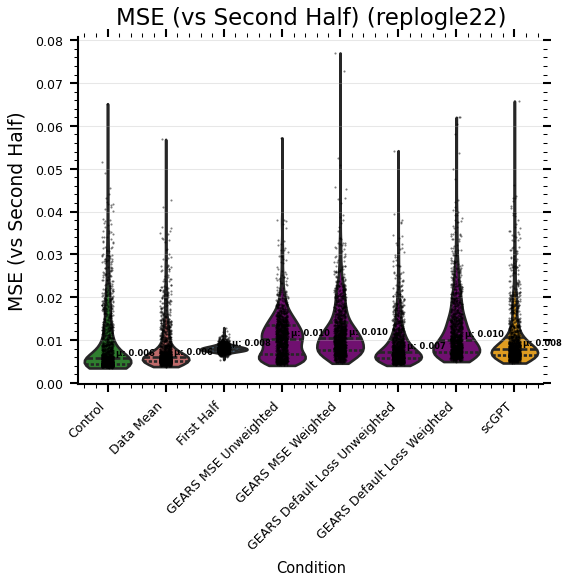

Plot saved to ./modeling_with_gears/replogle22/plots//condition_comparison_wmse.png


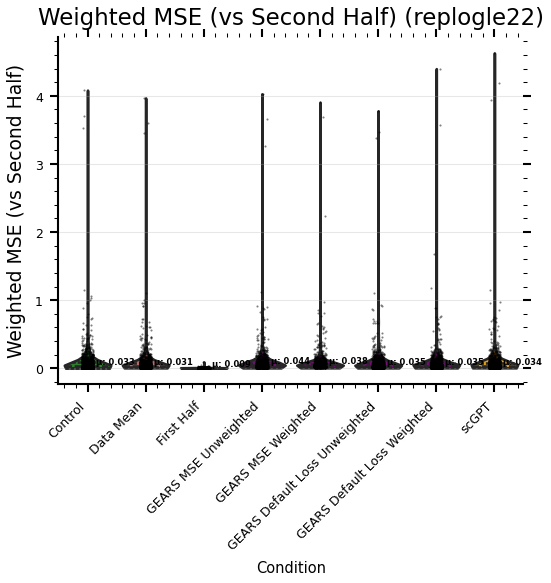

In [30]:
plot_predictive_conditions_boxplot(df_for_plotting, 'MSE', 'MSE (vs Second Half)', 'MSE (vs Second Half)', PLOT_DIR, DATASET_NAME)
plot_predictive_conditions_boxplot(df_for_plotting, 'WMSE', 'Weighted MSE (vs Second Half)', 'Weighted MSE (vs Second Half)', PLOT_DIR, DATASET_NAME)

Plot saved to ./modeling_with_gears/replogle22/plots//condition_comparison_r-squared_delta.png


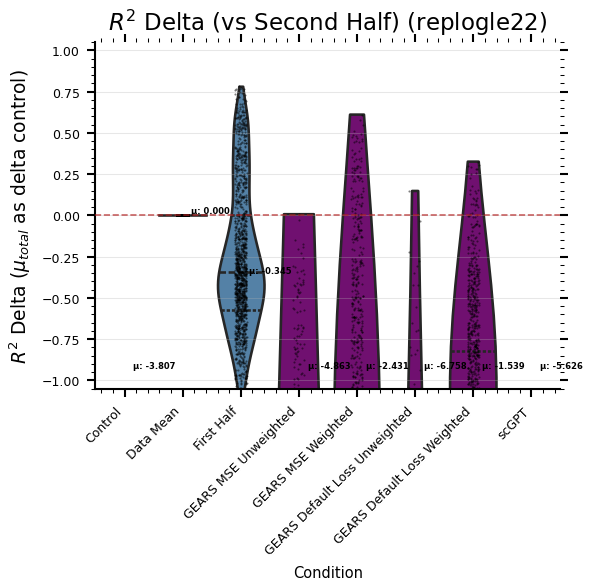

Plot saved to ./modeling_with_gears/replogle22/plots//condition_comparison_weighted_r-squared_delta.png


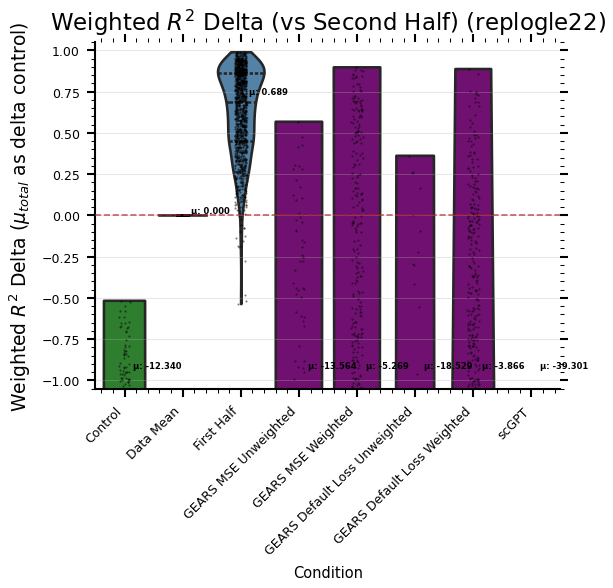

In [31]:
plot_predictive_conditions_boxplot(df_for_plotting, 'R-Squared Delta', r'$R^2$ Delta ($\mu_{total}$ as delta control)', r'$R^2$ Delta (vs Second Half)', PLOT_DIR, DATASET_NAME)
plot_predictive_conditions_boxplot(df_for_plotting, 'Weighted R-Squared Delta', r'Weighted $R^2$ Delta ($\mu_{total}$ as delta control)', r'Weighted $R^2$ Delta (vs Second Half)', PLOT_DIR, DATASET_NAME)

Plot saved to ./modeling_with_gears/replogle22/plots//condition_comparison_pearson_delta.png


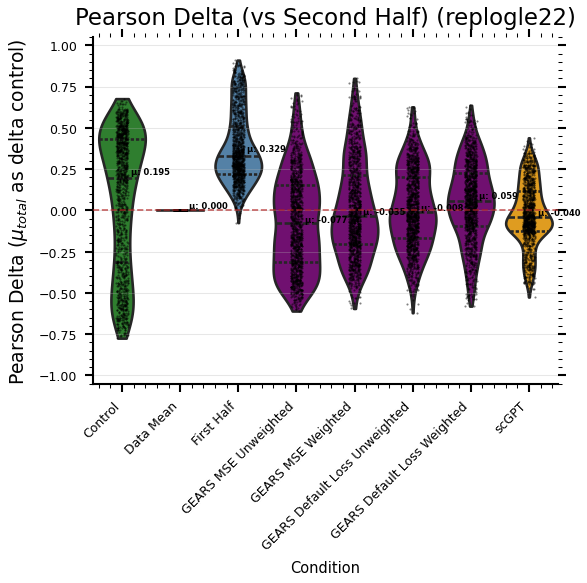

Plot saved to ./modeling_with_gears/replogle22/plots//condition_comparison_pearson_delta_degs.png


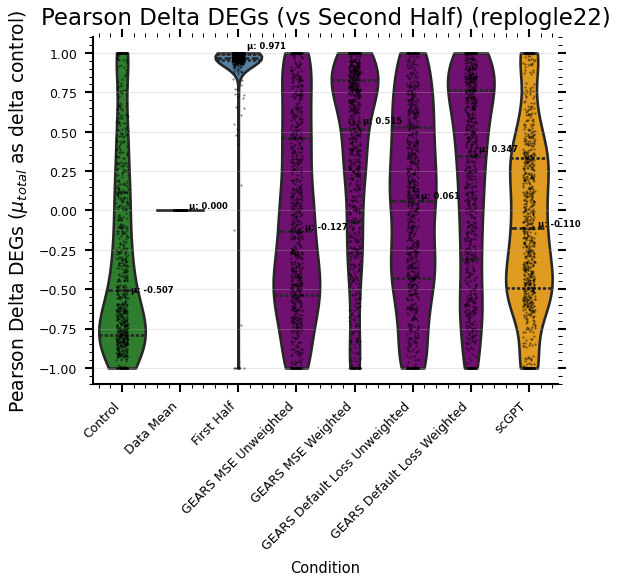

In [32]:
plot_predictive_conditions_boxplot(df_for_plotting, 'Pearson Delta', r'Pearson Delta ($\mu_{total}$ as delta control)', r'Pearson Delta (vs Second Half)', PLOT_DIR, DATASET_NAME)
plot_predictive_conditions_boxplot(df_for_plotting, 'Pearson Delta DEGs', r'Pearson Delta DEGs ($\mu_{total}$ as delta control)', r'Pearson Delta DEGs (vs Second Half)', PLOT_DIR, DATASET_NAME)